In [1]:
from scipy.interpolate import CubicSpline, CubicHermiteSpline
import argparse
import airsimneurips as airsim
import cvxpy as cp
import numpy as np
import time
import airsimneurips as airsim
import gtp
import baseline_racer
import baseline_racer_gtp
import hum_drum_racer
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
gate_pose_dicts = [ {   'orientation':  {   'w_val': 1.0,
    'x_val': -0.0,
    'y_val': 0.0,
    'z_val': 0.0},
    'position':  {   'x_val': 0.0,
    'y_val': 2.0,
    'z_val': 2.0199999809265137}},  {   'orientation':  {   'w_val': 0.9659256935119629,
    'x_val': 0.0,
    'y_val': -0.0,
    'z_val': -0.2588196396827698},
    'position':  {   'x_val': 1.5999999046325684,
    'y_val': 10.800000190734863,
    'z_val': 2.0199999809265137}},  {   'orientation':  {   'w_val': 0.8660249710083008,
    'x_val': 0.0,
    'y_val': -0.0,
    'z_val': -0.5000007152557373},
    'position':  {   'x_val': 8.887084007263184,
    'y_val': 18.478761672973633,
    'z_val': 2.0199999809265137}},  {   'orientation':  {   'w_val': 0.7071061134338379,
    'x_val': 0.0,
    'y_val': -0.0,
    'z_val': -0.7071074843406677},
    'position':  {   'x_val': 18.74375343322754,
    'y_val': 22.20650863647461,
    'z_val': 2.0199999809265137}},  {   'orientation':  {   'w_val': 0.7071061134338379,
    'x_val': 0.0,
    'y_val': -0.0,
    'z_val': -0.7071074843406677},
    'position':  {   'x_val': 30.04375457763672,
    'y_val': 22.20648956298828,
    'z_val': 2.0199999809265137}},  {   'orientation':  {   'w_val': 0.4999988079071045,
    'x_val': 0.0,
    'y_val': -0.0,
    'z_val': -0.8660261034965515},
    'position':  {   'x_val': 39.04375457763672,
    'y_val': 19.206478118896484,
    'z_val': 2.0199999809265137}},  {   'orientation':  {   'w_val': 0.17364656925201416,
    'x_val': 0.0,
    'y_val': -0.0,
    'z_val': -0.9848079681396484},
    'position':  {   'x_val': 45.74375534057617,
    'y_val': 11.706478118896484,
    'z_val': 2.0199999809265137}},  {   'orientation':  {   'w_val': 1.8477439880371094e-06,
    'x_val': -0.0,
    'y_val': 0.0,
    'z_val': 1.0},
    'position':  {   'x_val': 45.74375534057617,
    'y_val': 2.2064781188964844,
    'z_val': 2.0199999809265137}},  {   'orientation':  {   'w_val': 0.5000025629997253,
    'x_val': -0.0,
    'y_val': 0.0,
    'z_val': 0.8660238981246948},
    'position':  {   'x_val': 40.343753814697266,
    'y_val': -4.793521404266357,
    'z_val': 2.0199999809265137}},  {   'orientation':  {   'w_val': 0.7071094512939453,
    'x_val': -0.0,
    'y_val': 0.0,
    'z_val': 0.7071040272712708},
    'position':  {   'x_val': 30.74375343322754,
    'y_val': -7.893521785736084,
    'z_val': 2.0199999809265137}},  {   'orientation':  {   'w_val': 0.7071094512939453,
    'x_val': -0.0,
    'y_val': 0.0,
    'z_val': 0.7071040272712708},
    'position':  {   'x_val': 18.54375457763672,
    'y_val': -7.893521785736084,
    'z_val': 2.0199999809265137}},  {   'orientation':  {   'w_val': 0.8191542029380798,
    'x_val': -0.0,
    'y_val': 0.0,
    'z_val': 0.5735733509063721},
    'position':  {   'x_val': 9.543754577636719,
    'y_val': -5.093521595001221,
    'z_val': 2.0199999809265137}}]
gate_inner_dims_dict= {   'x_val': 1.6,
    'y_val': 0.2,
    'z_val': 1.6}
gate_outer_dims_dict= {   'x_val': 2.1333333333333333,
    'y_val': 0.2,
    'z_val': 2.1333333333333333}

In [10]:
# airsim.Quaternionr(x_val,y_val,z_val,w_val) # quaternion ordering
gate_poses = [
    airsim.Pose(
        airsim.Vector3r(
            d['position']['x_val'],
            d['position']['y_val'],
            d['position']['z_val']
        ),
        airsim.Quaternionr(
            d['orientation']['x_val'],
            d['orientation']['y_val'],
            d['orientation']['z_val'],
            d['orientation']['w_val']
        )
    ) for d in gate_pose_dicts
]
gate_inner_dims = airsim.Vector3r(
    gate_inner_dims_dict['x_val'],
    gate_inner_dims_dict['y_val'],
    gate_inner_dims_dict['z_val'],
)
gate_outer_dims = airsim.Vector3r(
    gate_outer_dims_dict['x_val'],
    gate_outer_dims_dict['y_val'],
    gate_outer_dims_dict['z_val'],
)
gate_directions = [gtp.rotate_vector(g.orientation, airsim.Vector3r(0,1,0)) for g in gate_poses]

drone_names = ["drone_1", "drone_2"]
drone_params = [
    {"r_safe": 0.5,
     "r_coll": 0.5,
     "v_max": 80.0,
     "a_max": 40.0},
    {"r_safe": 0.4,
     "r_coll": 0.3,
     "v_max": 20.0,
     "a_max": 10.0}]
parser = argparse.ArgumentParser(description='')
parser.add_argument('--dt', type=float, default=0.05)
parser.add_argument('--n', type=int, default=14)
parser.add_argument('--blocking_behavior', dest='blocking', action='store_true', default=False)
parser.add_argument('--vel_constraints', dest='vel_constraints', action='store_true', default=False)
parser.add_argument('--plot_gtp', dest='plot_gtp', action='store_true', default=False)
parser.add_argument('--level_name', type=str, choices=["Soccer_Field_Easy", "Soccer_Field_Medium", "ZhangJiaJie_Medium", "Building99_Hard", 
    "Qualifier_Tier_1", "Qualifier_Tier_2", "Qualifier_Tier_3"], default="ZhangJiaJie_Medium")
parser.add_argument('--enable_viz_traj', dest='viz_traj', action='store_true', default=False)
parser.add_argument('--race_tier', type=int, choices=[1,2,3], default=1)
traj_params = parser.parse_known_args()[0]

start_state = airsim.MultirotorState()

In [4]:
controller = gtp.IBRController(traj_params,drone_params,gate_poses)

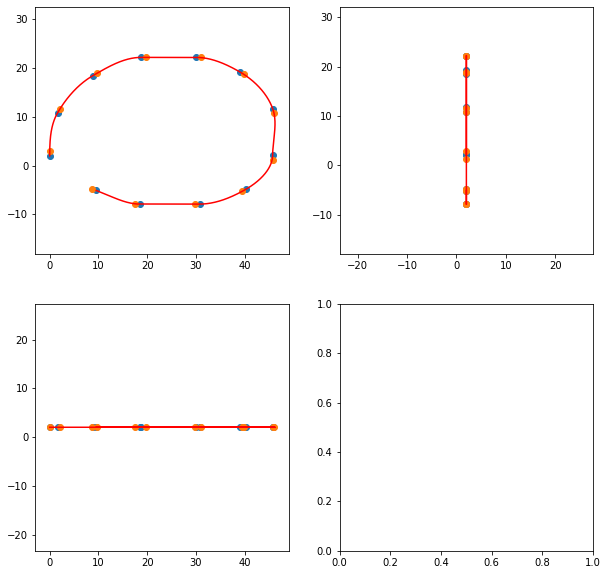

In [5]:
fig, axs = plt.subplots(2, 2,figsize=(10,10))
axs[0,0].plot([c[0] for c in controller.track.track_centers],[c[1] for c in controller.track.track_centers],"red")
axs[0,0].scatter([g.position.x_val for g in gate_poses],[g.position.y_val for g in gate_poses])
axs[0,0].scatter([g.position.x_val + d.x_val for (g,d) in zip(gate_poses,gate_directions)],
            [g.position.y_val + d.y_val for (g,d) in zip(gate_poses,gate_directions)])
axs[0,0].axis('equal')

axs[1,0].plot([c[0] for c in controller.track.track_centers],[c[2] for c in controller.track.track_centers],"red")
axs[1,0].scatter([g.position.x_val for g in gate_poses],[g.position.z_val for g in gate_poses])
axs[1,0].scatter([g.position.x_val + d.x_val for (g,d) in zip(gate_poses,gate_directions)],
            [g.position.z_val + d.z_val for (g,d) in zip(gate_poses,gate_directions)])
axs[1,0].axis('equal')

axs[0,1].plot([c[2] for c in controller.track.track_centers],[c[1] for c in controller.track.track_centers],"red")
axs[0,1].scatter([g.position.z_val for g in gate_poses],[g.position.y_val for g in gate_poses])
axs[0,1].scatter([g.position.z_val + d.z_val for (g,d) in zip(gate_poses,gate_directions)],
            [g.position.y_val + d.y_val for (g,d) in zip(gate_poses,gate_directions)])
axs[0,1].axis('equal')
axs[0,1].set_ylim(ymin=-18,ymax=32)
# axs[0,1].set_ylim(ymin=axs[0,0].get_ylim()[0],ymax=axs[0,0].get_ylim()[1])
plt.show()

# visualize GTP trajectories

In [47]:
start_pos = start_state.kinematics_estimated.position
p0 = [start_pos.x_val, start_pos.y_val, start_pos.z_val]
joint_p0 = np.concatenate([p0-np.array([[2,0,0]]),p0+np.array([[2,0,0]])])
ego_id = 1
base_traj = controller.init_trajectory(ego_id,joint_p0[ego_id,:])
ego_traj = controller.iterative_br(ego_id,joint_p0)

WARN: relaxing track constraints
WARN: relaxing track constraints
WARN: relaxing track constraints
WARN: relaxing track constraints
WARN: relaxing track constraints
Total IBR solution time:  1.6562316417694092


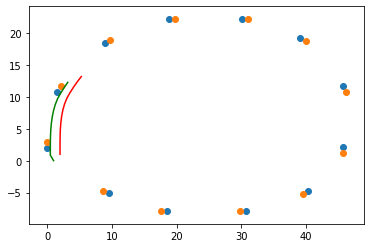

In [48]:
plt.scatter([g.position.x_val for g in gate_poses],[g.position.y_val for g in gate_poses])
plt.scatter([g.position.x_val + d.x_val for (g,d) in zip(gate_poses,gate_directions)],
            [g.position.y_val + d.y_val for (g,d) in zip(gate_poses,gate_directions)])
plt.plot(base_traj[:,0],base_traj[:,1],"red")
plt.plot(ego_traj[:,0],ego_traj[:,1],"green")

In [44]:
controller.dt

0.05

# visualize global trajectories

In [49]:
optimizer = hum_drum_racer.GlobalTrajectoryOptimizer(traj_params,drone_params[1],gate_poses,gate_inner_dims,gate_outer_dims)

In [50]:
pos,vel,accel,dt = optimizer.compute_global_optimal_trajectory(start_state,
    n = 5,
    dt_min = 0.05)

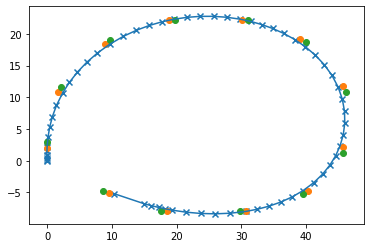

In [51]:
plt.scatter([p[0] for p in pos],[p[1] for p in pos],marker="x")
plt.plot([p[0] for p in pos],[p[1] for p in pos])
plt.scatter([g.position.x_val for g in gate_poses],[g.position.y_val for g in gate_poses])
plt.scatter([g.position.x_val + d.x_val for (g,d) in zip(gate_poses,gate_directions)],
            [g.position.y_val + d.y_val for (g,d) in zip(gate_poses,gate_directions)])

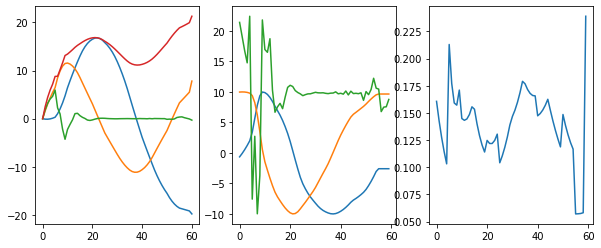

In [9]:
fig, axs = plt.subplots(1,3,figsize=(10,4))
axs[0].plot(vel)
axs[0].plot([np.linalg.norm(v) for v in vel])
axs[1].plot(accel)
axs[2].plot(dt)
plt.show()